# Coalescent estimation using PyTorch and torchtree

> Mathieu Fourment, University of Technology Sydney

# Table of contents
1. [The coalescent](#coalescent)
2. [Variational inference](#vb)
3. [Example: HCV](#hcv)
    1. [Variational inference](#hcv-vb)
    2. [Hamiltonian Monte Carlo](#hcv-hmc)

## The coalescent  <a name="coalescent"></a>

Let the coalescent times arising from genealogy $T$ of $N$ taxa be denoted $t_N = 0 < t_{N-1}< \dots< t_1$. The number of lineages associated with each interval $u_k = t_{k-1} - t_k$ is denoted $n_k$ and the vector concatenating the number of lineages is denoted $\boldsymbol{n}$.

### Constant population size
The joint distrubtion of the coalescent times given a constant population size $\theta$ is:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n}, \theta) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, \theta)\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{\theta} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta} \right]\\
\end{align}

The waiting time until the next coalescent event is exponentially distributed with rate ${n_{k} \choose 2}\frac{1}{\theta}$.


### Non parameteric population size
Suppose the function $Ne(t)$ describes the effective population size as we move into the past. The probability to observe $t_1, \dots, t_{N-1}$ given $Ne(t)$ can be written as:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n}, Ne(t)) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, Ne(t))\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{Ne(t_{k-1})} \exp \left[ -\int_{t_{k}}^{t_{k-1}} {n_{k} \choose 2} \frac{1}{Ne(t)} dt \right]\\
\end{align}

Since the integral is intractable we assume that changes in the trajectory of $Ne(t)$ coincinde with coalescent events, a piecewise constant trajectory of the population size function can be defined as $Ne(t) = \theta_k$ for $t_k < t \leq t_{k-1}$. Plugging $Ne(t) = \sum_{k=2}^N \theta_k 1_{(t_k,t_{k-1})}(t)$ in the previous equation gives the joint distribution:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n},\boldsymbol{\theta}) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, \theta_k)\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{\theta_k} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta_k} \right]
\end{align}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy import integrate
import torchtree
from torchtree.distributions.inverse_gamma import InverseGamma
from torchtree.evolution.coalescent import (ConstantCoalescent,
                                            PiecewiseConstantCoalescent)
from tqdm.notebook import tqdm

sys.path.append(os.path.abspath('../lib'))
from drawing import draw_tree
from tree import random_tree_from_heights

In [3]:
print("versions:")
print(f"torch {torch.__version__}")
print(f"torchtree {torchtree.__version__}")

versions:
torch 1.13.1
torchtree 1.0.2-dev


In [4]:
_ = torch.manual_seed(0)

## Simulated constant size coalescent

In [5]:
def binom(lineages):
    return lineages *(lineages - 1)/2

# simulate coalescent intervals for homochronous data
def simulate(theta, taxon_count):
    lineages = torch.arange(taxon_count, 1, -1)
    cf = binom(lineages)
    intervals = torch.distributions.Exponential(cf/theta).sample()
    return {'intervals': intervals,
            'heights': intervals.cumsum(0),
            'lineages': lineages}

# calculate probability of intervals given population size
def constant_log_prob(intervals, lineages, theta):
    cf = binom(lineages)
    return torch.sum((cf/theta).log() - cf/theta*intervals, -1)

We are going to simulate 49 coalescent intervals using a population size of 4. This scenario corresponds to a tree consisting of 50 homochronous taxa.

In [6]:
taxon_count = 50
true_theta = torch.tensor(4)
sim = simulate(true_theta, taxon_count)
heights_list = list(sim['heights'])
lineages = sim['lineages']
intervals = sim['intervals']

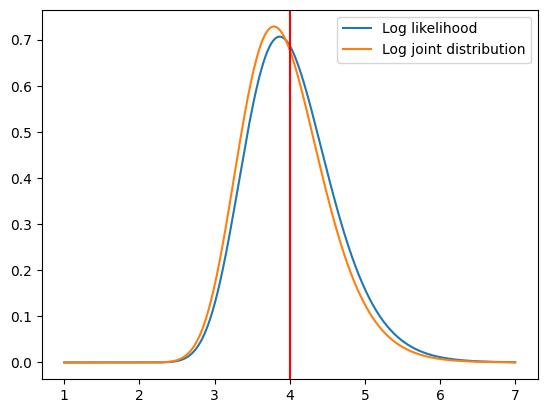

In [7]:
x = torch.arange(1,7, 0.001)

# log likelihood along x
y1 = constant_log_prob(sim['intervals'], sim['lineages'], x.unsqueeze(-1))
# log joint likelihood along x
y = y1 - x.log()

y1 = torch.exp(y1 - torch.max(y1))
y1 = y1/torch.sum(y1*0.001)

y = torch.exp(y - torch.max(y))
y = y/torch.sum(y*0.001)

plt.plot(x, y1, label='Log likelihood')
plt.plot(x, y, label='Log joint distribution')
plt.axvline(true_theta, c='r')
plt.legend(loc="upper right")
plt.show()

## Fast approximation of population size distribution

The maximum likelihood estimator is:
$$\hat{\theta} = \frac{1}{N-1}\sum_{k=2}^N {k\choose 2} (t_{k-1} - t_k) $$

The maximum a posteriori estimator is:
$$\hat{\theta}_{MAP} = \frac{1}{N}\sum_{k=2}^N {k\choose 2} (t_{k-1} - t_k) $$

In [8]:
mle = torch.sum(binom(lineages) * intervals)/(taxon_count-1)
ml = constant_log_prob(sim['intervals'], sim['lineages'], mle)
var = -1.0/((taxon_count-1)/mle**2 - 2.0*torch.sum(binom(lineages) * intervals)/(mle**3))
print('ML  theta = {:.2f} f(theta) = {:.2f} var(theta) = {:.2f}'.format(mle, ml, var))

mape = torch.sum(binom(lineages) * intervals)/(taxon_count)
mapp = constant_log_prob(sim['intervals'], sim['lineages'], mape) - mape.log()
var = -1.0/((taxon_count+1)/mape**2 - 2.0*torch.sum(binom(lineages) * intervals)/(mape**3))
print('MAP theta = {:.2f} f(theta) = {:.2f} var(theta) = {:.2f}'.format(mape, mapp, var))

ML  theta = 3.87 f(theta) = 143.83 var(theta) = 0.30
MAP theta = 3.79 f(theta) = 142.48 var(theta) = 0.29


Using the Laplace method and the mean and variance from the normal approximation the parameters of the lognormal distribution are:

In [9]:
d2logP = (taxon_count+1)/mape**2 - 2.0*torch.sum(binom(lineages) * intervals)/(mape**3)
q_sigma_map = torch.sqrt(-1.0/(d2logP*mape*mape))
q_mu_map = torch.log(mape) + q_sigma_map*q_sigma_map
print('mu = {:.3f} sigma = {:.3f}'.format(q_mu_map, q_sigma_map))

mu = 1.352 sigma = 0.143


Similarly the parameters of the gamma distribution can be estimated:

In [10]:
q_rate_map = mape * -d2logP
q_shape_map = q_rate_map*mape + 1.0
print('shape = {:.3f} rate = {:.3f}'.format(q_shape_map, q_rate_map))

shape = 50.000 rate = 12.935


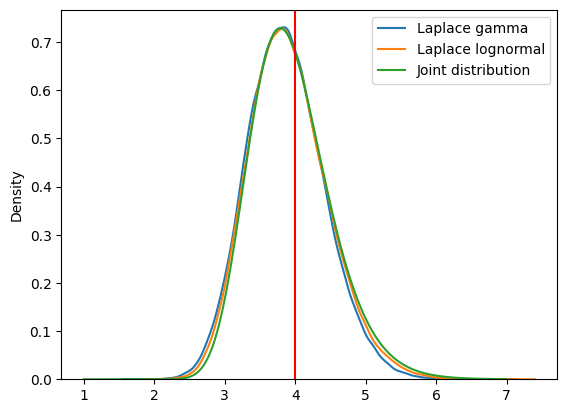

In [11]:
q_gamma = torch.distributions.Gamma(q_shape_map, q_rate_map)
xd = q_gamma.sample((100000,))
sns.kdeplot(xd, label='Laplace gamma')

q_lnorm = torch.distributions.LogNormal(q_mu_map, q_sigma_map)
xd = q_lnorm.sample((100000,))
sns.kdeplot(xd, label='Laplace lognormal')

plt.plot(x, y, label='Joint distribution')
plt.axvline(true_theta, c='r')
plt.legend(loc="upper right")
plt.show()

The plot above shows that the distribution of the population size parameter is somehow asymmetric, the right tail being a bit fatter than the right one. Clearly a truncated normal distribution would struggle to fit this distribution.

## Variational inference  <a name="vb"></a>
Next we are going to estimate the population parameter of a constant size coalescent model using the intervals we just simulated. The parameter is estimated using Variational inference with the PyTorch framework. The support of the population size parameter is $\mathbb{R}^+$ so a log transformation is used to map it on the real line. It is optimized using the Adam algorithm.

It is common to use the Jeffreys prior on the population size parameter:
$$f(\theta) \propto \frac{1}{\theta}$$

The posterior distribution of the population size is:

\begin{align}
p(\theta \mid t_1, \dots, t_{N-1}, T) &\propto p(t_1, \dots, t_{N-1} \mid \theta, T) f(\boldsymbol{\theta})\\
&= \frac{1}{\theta} \prod_{k=2}^{N} \frac{1}{\theta} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta} \right]
\end{align}

Variational Bayes methods provide an analytical approximation to the posterior probability and a lower bound for the marginal likelihood.
The main idea is to choose a family of distributions $q$ parametrised with parameters $\boldsymbol{\phi}$ and to minimize the Kullback Leibler divergence from variational distribution $q$ to the posterior distribution $p$ of interest

$$ \boldsymbol{\phi}^{*} = \text{argmin}_{\boldsymbol{\phi} \in \boldsymbol{\Phi}}  \mathrm{KL}(q(\boldsymbol{\theta}; \boldsymbol{\phi}) \parallel p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})). $$

It is difficult to minimise the KL divergence directly but much easier to minimize a function that is equal to it up to a constant.
Expanding the KL divergence we get

$$\begin{aligned}
\mathrm{KL}(q(\boldsymbol{\theta}; \boldsymbol{\phi}) \parallel p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})) &= \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})] - \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})] \\
  & = \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})] - \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta}, t_1, \dots, t_{N-1})] + \log p(t_1, \dots, t_{N-1})\\
    & = -\textrm{ELBO}(\boldsymbol{\phi}) + \log p(t_1, \dots, t_{N-1}),
\end{aligned}$$
where $\textrm{ELBO}(\boldsymbol{\phi}) = \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta}, t_1, \dots, t_{N-1})] - \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})]$.
This equation suggests that the $\textrm{ELBO}(\boldsymbol{\phi})$ is the lower bound of the evidence: $\log p(t_1, \dots, t_{N-1}) \geq \textrm{ELBO}(\boldsymbol{\phi})$.


Instead of minimizing KL divergence, we maximize  the evidence lower bound:
$$ \textrm{ELBO}(\boldsymbol{\phi}) = \mathop{\mathbb{E}}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[\log p(t_1, \dots, t_{N-1}, \boldsymbol{\theta}) - \log q(\boldsymbol{\theta}; \boldsymbol{\phi})].$$


In [12]:
lr_lambda = lambda epoch: 1.0/math.sqrt(epoch+1)
sampling_times = torch.zeros(taxon_count)
heights = torch.cat((sampling_times, torch.tensor(heights_list)))

def calculate_elbo_constant(q_theta, size):
    z = q_theta.rsample(size)
    coalescent = ConstantCoalescent(z)
    logQ = q_theta.log_prob(z)
    logPrior = -z.log() # Jeffreys: 1/theta
    logP = coalescent.log_prob(heights)
    return  logP + logPrior - logQ

## Variational distribution: lognormal

In [13]:
theta_mu = torch.randn(1, requires_grad=True)
theta_sigma = torch.randn(1, requires_grad=True)

optimizer = torch.optim.Adam( (theta_mu, theta_sigma), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []
mu_grads = []
sigma_grads = []
mus = []
sigmas = []

def elbo_lognormal(size=(1,)):
    q_theta = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
    return calculate_elbo_constant(q_theta, size).mean()

iters = tqdm(range(50000), mininterval=1)
for epoch in iters:
    mus.append(theta_mu.item())
    sigmas.append(theta_sigma.exp().item())
    
    loss = -elbo_lognormal()
    
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    mu_grads.append(theta_mu.grad.item())
    sigma_grads.append(theta_sigma.grad.item()**2)
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_lognormal((100,)).item()))

  0%|          | 0/50000 [00:00<?, ?it/s]

Final ELBO: -116.28555297851562


The next two plots show the full trajectory of the ELBO on the left and the trajectory for the last 40000 iterations on the right. The ELBO has stabilized around -121.

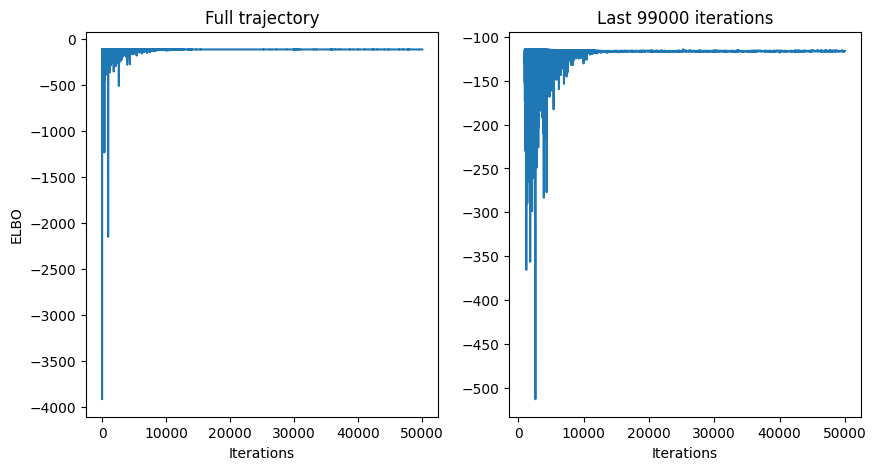

In [14]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(elbo_hist)
axes[0].set_title('Full trajectory')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('ELBO')

axes[1].plot(list(range(1000, len(elbo_hist))), elbo_hist[1000:])
axes[1].set_title('Last 99000 iterations')
axes[1].set_xlabel('Iterations')
plt.show()

This plot shows the estimated lognormal distribution (variational distribution). The red line represents the true value of the population size parameter.

### KL(p|q) using a technique from adaptive importance sampling (Oh & Berger, 1992)

In [15]:
def calculate_klpq_constant_for_grad(q_theta, size):
    z = q_theta.sample(size)
    coalescent = ConstantCoalescent(z)
    log_q = q_theta.log_prob(z)
    log_p = coalescent.log_prob(heights) - z.log()
    log_w = log_p - log_q.detach()
    w = torch.exp(log_w - log_w.max())
    w_norm = w / w.sum()
    return -torch.sum(w_norm * log_q)

def calculate_klpq_constant(q_theta, size):
    z = q_theta.sample(size)
    coalescent = ConstantCoalescent(z)
    log_q = q_theta.log_prob(z)
    log_p = coalescent.log_prob(heights) - z.log()
    log_w = log_p - log_q.detach()
    w = torch.exp(log_w - log_w.max())
    w_norm = w / w.sum()
    return torch.sum(w_norm * (log_p - log_q))

klpq_theta_mu = torch.randn(1, requires_grad=True)
klpq_theta_sigma = torch.randn(1, requires_grad=True)

optimizer = torch.optim.Adam( (klpq_theta_mu, klpq_theta_sigma), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
klpq_hist = []

iters = tqdm(range(5000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.LogNormal(klpq_theta_mu, klpq_theta_sigma.exp())
    loss = calculate_klpq_constant_for_grad(q_theta, (10,))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    with torch.no_grad():
        loss = calculate_klpq_constant(q_theta, (10,))
        klpq_hist.append(loss.item())
    iters.set_description('ELBO: {}'.format(klpq_hist[-1]), refresh=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

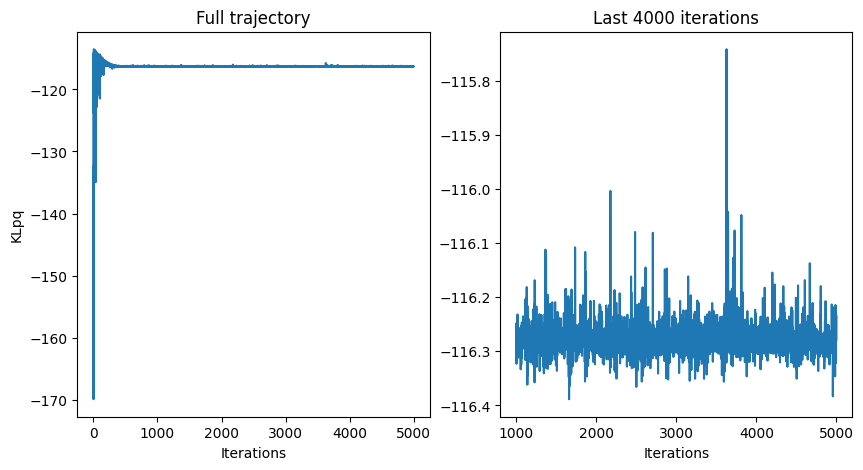

In [16]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(klpq_hist)
axes[0].set_title('Full trajectory')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('KLpq')

# axes[1].plot(list(range(20000, len(klpq_hist))), elbo_hist[20000:])
axes[1].plot(list(range(1000, len(klpq_hist))), klpq_hist[1000:])
axes[1].set_title('Last 4000 iterations')
axes[1].set_xlabel('Iterations')
plt.show()

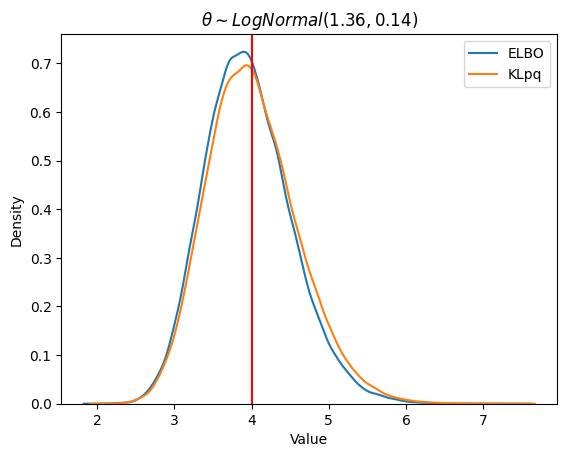

In [17]:
m = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
x = m.sample((100000,)).squeeze(-1)
m_klpq = torch.distributions.LogNormal(klpq_theta_mu, klpq_theta_sigma.exp())
x2 = m_klpq.sample((100000,)).squeeze(-1)
sns.kdeplot(x, label="ELBO")
sns.kdeplot(x2, label="KLpq")
plt.axvline(true_theta, c='r')
plt.xlabel('Value')
plt.title(r'$\theta \sim LogNormal({:.2f},{:.2f})$'.format(theta_mu.item(), theta_sigma.exp().item()))
plt.legend(loc="upper right")
plt.show()

## Variational distribution: inverse gamma

In [18]:
theta_alpha_i = torch.tensor([4.], requires_grad=True)
theta_beta_i = torch.tensor([4.], requires_grad=True)

optimizer = torch.optim.Adam( (theta_alpha_i, theta_beta_i), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist3 = []

def elbo_inverse_gamma(size=(1,)):
    q_theta = InverseGamma(theta_alpha_i.exp(), theta_beta_i.exp())
    return calculate_elbo_constant(q_theta, size).mean()

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    loss = -elbo_inverse_gamma()
    
    elbo_hist3.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist3[-1]), refresh=False)

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_inverse_gamma((100,)).item()))

  0%|          | 0/100000 [00:00<?, ?it/s]

Final ELBO: -116.28216552734375


## Variational distribution: gamma

In [19]:
theta_alpha = torch.tensor([torch.log(q_shape_map)], requires_grad=True)
theta_beta = torch.tensor([torch.log(q_rate_map)], requires_grad=True)

optimizer = torch.optim.Adam( (theta_alpha, theta_beta), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist2 = []
mu_grads2 = []
sigma_grads2 = []

    
def elbo_gamma(size=(1,)):
    q_theta = torch.distributions.Gamma(theta_alpha.exp(), theta_beta.exp())
    return calculate_elbo_constant(q_theta, size).mean()

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    loss = -elbo_gamma()
    
    elbo_hist2.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    mu_grads2.append(theta_alpha.grad.item())
    sigma_grads2.append(theta_beta.grad.item()**2)
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist2[-1]), refresh=False)
    
with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_gamma((100,)).item()))

  0%|          | 0/100000 [00:00<?, ?it/s]

Final ELBO: -116.27523803710938


In [20]:
def elbo_gamma_laplace(size=(1,)):
    q_theta = torch.distributions.Gamma(q_shape_map, q_rate_map)
    z = q_theta.rsample(size)
    z = z.unsqueeze(-1)
    coalescent = ConstantCoalescent(z)
    logQ = q_theta.log_prob(z)
    logPrior = -z # Jeffreys: 1/theta
    logP = coalescent.log_prob(heights)
    return (logP + logPrior - logQ).mean()

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_gamma_laplace((100,)).item()))

Final ELBO: -118.8412857055664


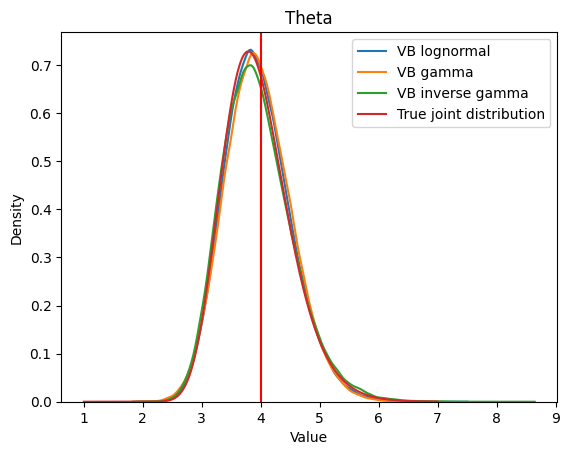

In [21]:
m = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
mg = torch.distributions.Gamma(theta_alpha.exp(), theta_beta.exp())
mig = InverseGamma(theta_alpha_i.exp(), theta_beta_i.exp())
x = m.sample((100000,)).squeeze(-1)
sns.kdeplot(x, label='VB lognormal')

xg = mg.sample((100000,)).squeeze(-1)
sns.kdeplot(xg, label='VB gamma')

xig = mig.sample((100000,)).squeeze(-1)
sns.kdeplot(xig, label='VB inverse gamma')

plt.plot(torch.arange(1,7, 0.001), y, label='True joint distribution')
plt.axvline(true_theta, c='r')
plt.xlabel('Value')
plt.title('Theta')

plt.legend(loc="upper right")
plt.show()

Visually the lognormal outperforms the gamma and inverse gamma distribution. The ELBO estimates can have high variance and might be of little use to discriminate between closely related models (in the KL sense).
What if we use these approximations to calculate the marginal likelihood using importance sampling with the variational distribution $q$ as the importance distribution. This yields the $\hat{p}_{\text{VBIS}}(t_1,\dots, t_{N-1})$ estimator:

$$
\hat{p}_{\text{VBIS}}(t_1,\dots, t_{N-1}) = \frac{1}{K} \sum_{i=1}^K \frac{p(t_1,\dots, t_{N-1} \mid \tilde{\boldsymbol{\theta}_i}) p(\tilde{\boldsymbol{\theta}_i})}{q_{\text{ELBO}}(\tilde{\boldsymbol{\theta}_i})}, \tilde{\boldsymbol{\theta}}_i \sim q_{\text{ELBO}}(\boldsymbol{\theta}).
$$

In [22]:
samples = 100000
m = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
z = m.sample((samples,))
lq = m.log_prob(z)
constant = ConstantCoalescent(z)
lp = constant.log_prob(heights) - z.log()
print('Lognormal log marginal = {}'.format(torch.logsumexp(lp-lq, 0).item() - torch.tensor(samples).log()))

mg = torch.distributions.Gamma(theta_alpha.exp(), theta_beta.exp())
z = mg.sample((samples,))
lq = mg.log_prob(z)
constant = ConstantCoalescent(z)
lp = constant.log_prob(heights) - z.log()
print('Gamma log marginal = {}'.format(torch.logsumexp(lp-lq, 0).item() - torch.tensor(samples).log()))

ll = lambda theta : np.exp(constant_log_prob(sim['intervals'], sim['lineages'], torch.tensor(theta)).numpy() - np.log(theta) - ml)
lml, _ = torch.tensor(integrate.quad(ll, 0, np.inf)).log() + ml
print('Quad log marginal      = {}'.format(lml))

Lognormal log marginal = -116.27903747558594
Gamma log marginal = -116.27861785888672
Quad log marginal      = 142.8001251220703


/var/folders/nj/lyp9fk5957l6crytrmyq4v1w0000gs/T/ipykernel_56660/1218401266.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  lml, _ = torch.tensor(integrate.quad(ll, 0, np.inf)).log() + ml


## Hepatitis C Outbreak in Egypt <a name="hcv"></a>

In [23]:
from torchtree.evolution.coalescent import PiecewiseConstantCoalescentModel, PiecewiseConstantCoalescentGridModel, FakeTreeModel
from torchtree.core.parameter import Parameter, TransformedParameter, ViewParameter
from torchtree.distributions.joint_distribution import JointDistributionModel
from torchtree.core.logger import ContainerLogger
from torchtree.distributions.distributions import Distribution
from torchtree.distributions.gmrf import GMRF
from logger import TqdmLogger
from torchtree.distributions.distributions import Distribution
from torchtree.optim.optimizer import Optimizer
from torchtree.variational.kl import ELBO, KLpqImportance, KLpq
from torchtree.optim.convergence import StanVariationalConvergence, VariationalConvergence
from torchtree.inference.sampler import Sampler
from torchtree.distributions.transforms import LogTransform
from torchtree.inference.mcmc.gmrf_block_updating import GMRFPiecewiseCoalescentBlockUpdatingOperator
from torchtree.variational.kl import MakovianScoreClimbing

In [24]:
hcv_heights_list = (
        0.337539776803851, 1.47598666181676, 2.59836642809404, 10.5419856428014, 10.6808211320844, 15.3216302200854,
        32.9562682261327, 35.2648938177678, 36.7219608418798, 36.737540711423, 37.2708231729614, 37.7849554073031,
        39.4937183636496, 39.5351866235332, 40.2051118111069, 40.272699980689, 42.8275583168662, 45.0143000059112,
        46.5121661847954, 47.1448952249262, 47.504526489029, 47.9616614709545, 48.3715795210146, 48.483790544288,
        48.7943022569899, 50.4087925250658, 51.2112016897755, 51.2609695712131, 51.878675348271, 54.1904624765934,
        55.4352237750807, 55.5550828199461, 55.9082058859295, 61.1133486466791, 61.2488301435699, 61.6467848736123,
        61.8450615919513, 63.090453292149, 66.1723097114625, 66.981821939552, 68.9496036301138, 69.0585863605563,
        69.3140166961911, 70.088816523003, 70.582823656852, 72.0200679613929, 72.0372853199532, 72.1961653985567,
        72.4862745825324, 74.6256268205132, 74.6985113851702, 78.4868903769909, 79.3977257023136, 83.4281836229148,
        85.2297867264788, 87.6518990828725, 89.1434858206649, 94.7629800718393, 224.733954965067, 232.942753855407,
        251.57871299307, 277.961578642117)
taxon_count = len(hcv_heights_list) + 1
heights = torch.cat((torch.zeros(taxon_count), torch.tensor(hcv_heights_list)), -1)

intervals = torch.tensor([0.0] + list(hcv_heights_list))
intervals = intervals[1:] - intervals[:-1]
lineages = torch.arange(taxon_count, 1, -1)
times = [1994. - x for x in hcv_heights_list]
mles = binom(lineages) * intervals
mle = torch.mean(mles)
print('MLE: {:.2f} log(MLE): {:.2f}'.format(mle, mle.log()))

MLE: 1378.86 log(MLE): 7.23


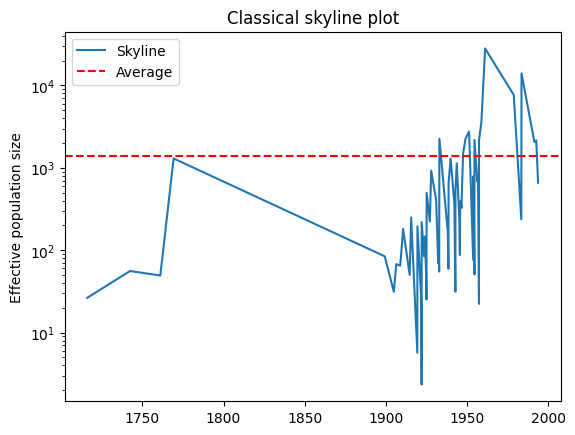

In [25]:
plt.plot(times, binom(lineages) * intervals, '-', label='Skyline')
plt.title('Classical skyline plot')
plt.ylabel('Effective population size')
plt.axhline(mle, linestyle='--', c='r', label='Average')
plt.yscale('log')
plt.legend(loc="upper left")
plt.show()

## Functions for creating skygrid and skyride models.

The `create_joint*` functions also return the parameters of the model (i.e. pop size and precision) and their unconstrained counterparts for sampling in an unconstrained space.


In [26]:

def create_parameters_exp(id_, value):
    log_param = Parameter(f"log_{id_}", value)
    param = TransformedParameter(id_, log_param, torch.distributions.ExpTransform())
    return param, log_param

def create_parameters_log(id_, value):
    param = Parameter(id_, value)
    log_param = TransformedParameter(f"log_{id_}", param, LogTransform())
    return param, log_param

def create_normal_hyperprior(id_, x, loc, scale):
    args = {"loc": Parameter(None, loc), "scale": Parameter(None, scale)}
    return Distribution(id_, torch.distributions.Normal, x, args)

def create_joint_skyride():
    pop_sizes, log_pop_sizes = create_parameters_exp("pop_sizes", torch.full((taxon_count-1,), 5.0))
    tree_model = FakeTreeModel(Parameter("heights", heights))
    skyride = PiecewiseConstantCoalescentModel("skyride", pop_sizes, tree_model)
    precision, log_precision = create_parameters_exp("precision",  torch.tensor([1.0]))
    gmrf = GMRF("gmrf", log_pop_sizes, precision)

    args = {"concentration": Parameter(None, torch.tensor(0.001)), "rate": Parameter(None, torch.tensor(0.001))}
    precision_prior = Distribution("precision_prior", torch.distributions.Gamma, precision, args)
    joint = JointDistributionModel("joint", [skyride, gmrf, precision_prior, precision])
    return joint, pop_sizes, precision, log_pop_sizes, log_precision

def create_joint_skyride_constrained(include_jac_pop_size=False):
    if not include_jac_pop_size:
        pop_sizes, log_pop_sizes = create_parameters_exp("pop_sizes", torch.full((taxon_count-1,), 5.0))
    else:
        pop_sizes, log_pop_sizes = create_parameters_log("pop_sizes", torch.full((taxon_count-1,), 5.0))
    tree_model = FakeTreeModel(Parameter("heights", heights))
    skyride = PiecewiseConstantCoalescentModel("skyride", pop_sizes, tree_model)
    
    precision = Parameter("precision", torch.tensor([1.0]))
    gmrf = GMRF("gmrf", log_pop_sizes, precision)

    args = {"concentration": Parameter(None, torch.tensor(0.001)),
             "rate": Parameter(None, torch.tensor(0.001))}
    precision_prior = Distribution("precision_prior", torch.distributions.Gamma, precision, args)

    log_theta0 = ViewParameter(None, log_pop_sizes, slice(1))
    theta0_prior = create_normal_hyperprior("theta0_prior", log_theta0, mle.log(), torch.tensor(10.0))
    
    joint_list = [skyride, gmrf, precision_prior, theta0_prior]
    if include_jac_pop_size:
        joint_list.append(log_pop_sizes)
    joint = JointDistributionModel("joint", joint_list)
    return joint, pop_sizes, precision, log_pop_sizes

def create_joint_skygrid(theta_count, cutoff):
    pop_sizes, log_pop_sizes = create_parameters_exp("pop_sizes", torch.full((theta_count,), 5.0))
    tree_model = FakeTreeModel(Parameter("heights", heights))
    grid = Parameter("grid", torch.linspace(0, cutoff, pop_sizes.shape[-1])[1:])
    skygrid = PiecewiseConstantCoalescentGridModel("skygrid", pop_sizes, grid, tree_model)
    precision, log_precision = create_parameters_exp("precision",  torch.tensor([1.0]))
    gmrf = GMRF("gmrf", log_pop_sizes, precision)

    args = {"rate": Parameter(None, torch.tensor(0.001)), "concentration": Parameter(None, torch.tensor(0.001))}
    precision_prior = Distribution("precision_prior", torch.distributions.Gamma, precision, args)
    joint = JointDistributionModel("joint", [skygrid, gmrf, precision_prior, precision])
    return joint, pop_sizes, precision, log_pop_sizes, log_precision

def create_lognormal(x, loc_value, scale_value):
    scale, scale_log = create_parameters_exp("scale", scale_value)
    args = {"loc": Parameter(None, loc_value), "scale": scale}
    return Distribution(f"{x.id}.var", torch.distributions.LogNormal, x, args), args["loc"], scale_log

def create_normal(x, loc_value, scale_value):
    scale, scale_log = create_parameters_exp("scale", scale_value)
    args = {"loc": Parameter(None, loc_value), "scale": scale}
    return Distribution(f"{x.id}.var", torch.distributions.Normal, x, args), args["loc"], scale_log

def create_gamma(x, concentration_value, rate_value):
    concentration, concentration_log = create_parameters_exp("concentration", concentration_value)
    rate, rate_log = create_parameters_exp("rate", rate_value)
    args = {"rate": rate, "concentration": concentration}
    return Distribution(f"{x.id}.var", torch.distributions.Gamma, x, args), concentration_log, rate_log

## Varational inference <a name="hcv-vb"></a>

### Transformation of population size parameters

\begin{align}
\tilde\theta_k &= \log\theta_k, k = 2, \dots, N \\
\Delta_i &= \tilde\theta_{i+1} - \tilde\theta_{i}, i = 2, \dots, N-1\\
\end{align}

## Meanfield on $\boldsymbol{\theta}$, centered parameterization, GMRF, and $Gamma(\tau)$

The gamma distribution is parameterized with the shape and rate parameters. The normal distribution is parameterized with the precision parameter $\tau=\frac{1}{\sigma^2}$.

\begin{align}
\begin{aligned}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, 1/\tau)\\
\tau \sim \mathit{Gamma}(0.001,0.001)\\
p_{\tilde\theta}(\tilde\theta_2, \dots, \tilde\theta_N, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{aligned}
\end{align}

\begin{align}
\begin{aligned}
p(\theta_2, \dots, \theta_N, \tau \mid T) &= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) |\det J|\\
&= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) \left|\prod_{i=2}^N\frac{d \log \theta_i}{d \theta_i}\right|\\
&= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) \left|\prod_{i=2}^N\frac{1}{\theta_i}\right|
\end{aligned}
\end{align}

### Variational model: meanfield gamma

Meanfield gamma distribution on $\boldsymbol{\theta}$:
$$ q(\boldsymbol\theta, \tau; \mu, \sigma, \boldsymbol\alpha, \boldsymbol\beta) = LogNormal(\tau; \mu, \sigma) \prod_{i=1}^N Gamma(\theta_i; \alpha_i, \beta_i)$$

#### Maximize ELBO

In [60]:
joint, pop_sizes, precision, log_pop_sizes = create_joint_skyride_constrained(True)

# parameters of the gamma distributions for the population size parameters
thetas_shape = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
thetas_rate = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
tau_mu = torch.tensor([0.1], requires_grad=True)
tau_sigma = torch.tensor([0.1], requires_grad=True)

# define variational distribution
q_pop_sizes, q_pop_sizes_conc, q_pop_sizes_rate = create_gamma(pop_sizes, thetas_shape, thetas_rate)
q_precision, q_precision_loc, q_precision_scale = create_lognormal(precision, tau_mu, tau_sigma)
q_elbo = JointDistributionModel("var", [q_pop_sizes, q_precision])

elbo = ELBO("elbo", q_elbo, joint, torch.Size((1,)))

optimizer = torch.optim.Adam((thetas_shape, thetas_rate, tau_mu, tau_sigma), lr=1.0)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
iterations = 10000
convergence_check = StanVariationalConvergence(elbo, 1000, (100,), iterations, tol_rel_obj=0.0001)
advi = Optimizer([q_pop_sizes_conc, q_pop_sizes_rate, 
                  q_precision_loc, q_precision_scale],
                  elbo, optimizer, iterations, scheduler=scheduler, convergence=convergence_check)
advi.run()

  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
     0       -87240.422             1.000            1.000
  1000         -537.076            81.218           81.218
  2000         -528.548            80.726           80.726
  3000         -523.663             0.013            0.013
  4000         -521.414             0.007            0.007
  5000         -519.111             0.004            0.004
  6000         -518.750             0.003            0.003
  7000         -517.083             0.002            0.002
  8000         -515.289             0.003            0.003
  9000         -512.005             0.005            0.005
  10000         -513.866             0.005            0.005


In [61]:
samples_elbo = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_elbo, 1)
sampler = Sampler(q_elbo, 1000, [logger])
sampler.run()
samples_elbo = torch.tensor(samples_elbo)

#### Minimize KL(p|q)

In [69]:
joint, pop_sizes, precision, log_pop_sizes = create_joint_skyride_constrained(True)

# parameters of the gamma distributions for the population size parameters
thetas_shape = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
thetas_rate = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
tau_mu = torch.tensor([0.1], requires_grad=True)
tau_sigma = torch.tensor([0.1], requires_grad=True)

# define variational distribution
q_pop_sizes, q_pop_sizes_conc, q_pop_sizes_rate = create_gamma(pop_sizes, thetas_shape, thetas_rate)
q_precision, q_precision_loc, q_precision_scale = create_lognormal(precision, tau_mu, tau_sigma)
q_klpq = JointDistributionModel("var", [q_pop_sizes, q_precision])

klpq = KLpqImportance("klpq", q_klpq, joint, torch.Size((10,)))
klpq2 = KLpq("klpq2", q_klpq, joint, torch.Size((10,)))

optimizer = torch.optim.Adam((thetas_shape, thetas_rate, tau_mu, tau_sigma), lr=1.0)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
iterations = 100000
convergence_check = StanVariationalConvergence(klpq2, 1000, (10,), iterations, tol_rel_obj=0.0001)
advi = Optimizer([q_pop_sizes_conc, q_pop_sizes_rate, 
                  q_precision_loc, q_precision_scale],
                  klpq, optimizer, iterations, scheduler=scheduler, convergence=convergence_check, maximize=False)
advi.run()

  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
     0       -75495.891             1.000            1.000
  1000         -775.270            48.690           48.690
  2000         -785.300            32.464            1.000
  3000         -765.477            24.355            0.513
  4000         -771.105            19.485            0.026
  5000         -750.452            16.242            0.027
  6000         -731.425            13.926            0.026
  7000         -729.202            12.185            0.026
  8000         -726.114            10.832            0.026
  9000         -714.540             9.750            0.021
  10000         -703.121             9.652            0.016
  11000         -702.701             0.014            0.014
  12000         -697.844             0.013            0.012
  13000         -701.886             0.011            0.007
  14000         -697.209             0.011            0.007
  15000         -692.817             0.009

In [63]:
samples_klpq = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_klpq, 1)
sampler = Sampler(q_klpq, 1000, [logger])
sampler.run()
samples_klpq = torch.tensor(samples_klpq)

#### Minimize KL(p|q) with MCMC moves

In [64]:
joint, pop_sizes, precision, log_pop_sizes = create_joint_skyride_constrained(True)

# parameters of the gamma distributions for the population size parameters
thetas_shape = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
thetas_rate = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
tau_mu = torch.tensor([0.1], requires_grad=True)
tau_sigma = torch.tensor([0.1], requires_grad=True)

# define variational distribution
q_pop_sizes, q_pop_sizes_conc, q_pop_sizes_rate = create_gamma(pop_sizes, thetas_shape, thetas_rate)
q_precision, q_precision_loc, q_precision_scale = create_lognormal(precision, tau_mu, tau_sigma)
operator = GMRFPiecewiseCoalescentBlockUpdatingOperator("bu", [pop_sizes, precision], joint._distributions.skyride, joint._distributions.gmrf, 1, 0.24, 2.)

q_klpq_bu = JointDistributionModel("var", [q_pop_sizes, q_precision])
msc = MakovianScoreClimbing("msc", q_klpq_bu, joint, operator, (10,))

optimizer = torch.optim.Adam((thetas_shape, thetas_rate, tau_mu, tau_sigma), lr=1.)
lr_lambda = lambda epoch: 1.0/math.sqrt(epoch+1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
iterations = 100000
convergence_check = StanVariationalConvergence(msc, 1000, (10,), iterations, tol_rel_obj=0.001)
advi = Optimizer([q_pop_sizes_conc, q_pop_sizes_rate, 
                  q_precision_loc, q_precision_scale],
                  msc, optimizer, iterations, scheduler=scheduler, convergence=convergence_check, maximize=False)
advi.run()

  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
     0      3584248.500             1.000            1.000
  1000         2710.905           661.080          661.080
  2000         -131.660           447.917           21.590
  3000          381.883           336.274           11.467
  4000           99.533           269.586            2.837
  5000         -363.047           224.868            2.091
  6000         -298.957           192.774            1.345
  7000         -377.820           168.704            1.309
  8000         -404.434           149.966            1.274
  9000         -373.052           134.978            1.137
  10000         -364.198           134.880            0.744
  11000         -470.608             2.787            0.220   MAY BE DIVERGING... INSPECT ELBO
  12000         -457.523             0.631            0.212   MAY BE DIVERGING... INSPECT ELBO
  13000         -486.359             0.502            0.146   MAY BE DIVERGING... INSPECT EL

In [65]:
samples_klpq_bu = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_klpq_bu, 1)
sampler = Sampler(q_klpq_bu, 1000, [logger])
sampler.run()
samples_klpq_bu = torch.tensor(samples_klpq_bu)

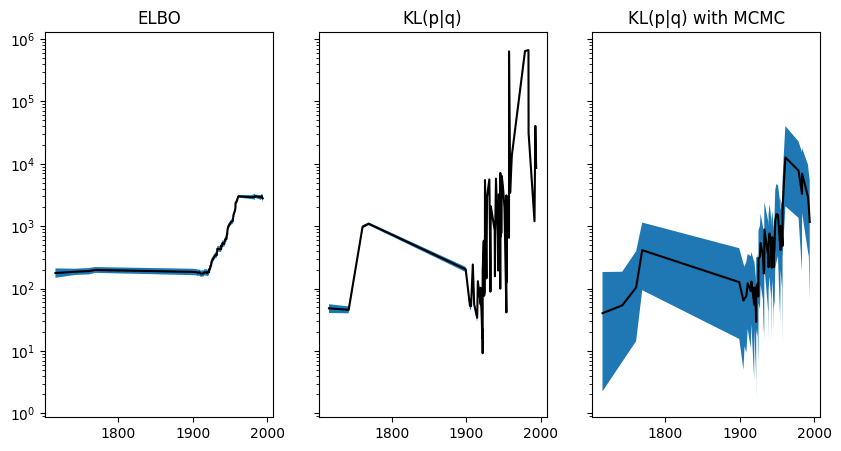

In [68]:
f, axes = plt.subplots(1, 3, figsize=(10,5), sharey=True)

thetas = samples_elbo[:, 1:-1]
mm =torch.mean(thetas, 0)
quants = torch.quantile(thetas, torch.tensor((0.025, 0.5, 0.975)), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')
axes[0].set_title("ELBO")

thetas = samples_klpq[:, 1:-1]
mm =torch.mean(thetas, 0)
quants = torch.quantile(thetas, torch.tensor((0.025, 0.5, 0.975)), 0)
axes[1].plot(times, quants[1], 'k-')
axes[1].fill_between(times, quants[0], quants[2])
axes[1].set_yscale('log')
axes[1].set_title("KL(p|q)")


thetas = samples_klpq_bu[:, 1:-1]
mm =torch.mean(thetas, 0)
quants = torch.quantile(thetas, torch.tensor((0.025, 0.5, 0.975)), 0)
axes[2].plot(times, quants[1], 'k-')
axes[2].fill_between(times, quants[0], quants[2])
axes[2].set_yscale('log')
axes[2].set_title("KL(p|q) with MCMC")

plt.show()

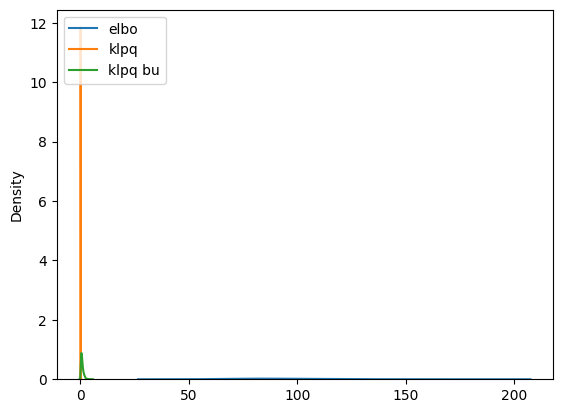

In [67]:
sns.kdeplot(samples_elbo[:, -1], label="elbo")
sns.kdeplot(samples_klpq[:, -1], label="klpq")
sns.kdeplot(samples_klpq_bu[:, -1], label="klpq bu")
plt.legend(loc="upper left")
plt.show()

### Variational model: meanfield normal on $\boldsymbol{{\tilde\theta}}$

$$ q(\boldsymbol{\tilde\theta}, \tau; \mu, \sigma, \boldsymbol\alpha, \boldsymbol\beta) = LogNormal(\tau; \mu, \sigma) \prod_{i=1}^N Normal({\tilde\theta}_i; \mu_i, \sigma^2_i)$$

#### Maximize ELBO

In [35]:
joint, pop_sizes, precision, log_pop_sizes = create_joint_skyride_constrained(include_jac_pop_size=False)

thetas_mu = torch.tensor([8.]*(taxon_count-1), requires_grad=True)
thetas_sigma = torch.tensor([-2.]*(taxon_count-1), requires_grad=True)
tau_mu = torch.tensor([4.2], requires_grad=True)
tau_sigma = torch.tensor([-1.7], requires_grad=True)

q_pop_sizes, q_pop_sizes_loc, q_pop_sizes_scale = create_normal(log_pop_sizes, thetas_mu, thetas_sigma)
q_precision, q_precision_loc, q_precision_scale = create_lognormal(precision, tau_mu, tau_sigma)
q_elbo_logn = JointDistributionModel("var", [q_pop_sizes, q_precision])
elbo = ELBO("elbo", q_elbo_logn, joint, torch.Size((1,)))

optimizer = torch.optim.Adam((thetas_mu, thetas_sigma, tau_mu, tau_sigma), lr=1.0)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
iterations = 100000
convergence_check = StanVariationalConvergence(elbo, 10000, (100,), iterations, tol_rel_obj=0.0001)
advi = Optimizer([q_pop_sizes_loc, q_pop_sizes_scale, 
                  q_precision_loc, q_precision_scale],
                  elbo, optimizer, iterations, scheduler=scheduler, convergence=convergence_check )
advi.run()

  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
     0         -576.429             1.000            1.000
  10000         -480.683             0.600            0.600
  20000         -480.095             0.100            0.100
  30000         -480.973             0.002            0.002
  40000         -480.483             0.001            0.001
  50000         -480.322             0.001            0.001
  60000         -480.714             0.001            0.001
  70000         -480.367             0.001            0.001
  80000         -480.638             0.001            0.001
  90000         -479.900             0.001            0.001
  100000         -480.662             0.002            0.002


In [36]:
samples_elbo_logn = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_elbo_logn, 1)
sampler = Sampler(q_elbo_logn, 1000, [logger])
sampler.run()
samples_elbo_logn = torch.tensor(samples_elbo_logn)

#### Minimize KL(p|q)

In [37]:
joint, pop_sizes, precision, log_pop_sizes = create_joint_skyride_constrained(include_jac_pop_size=False)

thetas_mu = torch.tensor([8.]*(taxon_count-1), requires_grad=True)
thetas_sigma = torch.tensor([-2.]*(taxon_count-1), requires_grad=True)
tau_mu = torch.tensor([1.], requires_grad=True)
tau_sigma = torch.tensor([-1.7], requires_grad=True)

q_pop_sizes, q_pop_sizes_loc, q_pop_sizes_scale = create_normal(log_pop_sizes, thetas_mu, thetas_sigma)
q_precision, q_precision_loc, q_precision_scale = create_lognormal(precision, tau_mu, tau_sigma)
q_klpq_logn = JointDistributionModel("var", [q_pop_sizes, q_precision])

klpq = KLpqImportance("klpq", q_klpq_logn, joint, torch.Size((10,)))
klpq2 = KLpq("klpq2", q_klpq_logn, joint, torch.Size((10,)))

optimizer = torch.optim.Adam((thetas_mu, thetas_sigma, tau_mu, tau_sigma), lr=0.1)
iterations = 100000
convergence_check = StanVariationalConvergence(klpq2, 10000, (10,), iterations, tol_rel_obj=0.0001)
advi = Optimizer([q_pop_sizes_loc, q_pop_sizes_scale, 
                  q_precision_loc, q_precision_scale],
                  klpq, optimizer, iterations, scheduler=scheduler, convergence=convergence_check, maximize=False)
advi.run()

  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
     0         -585.634             1.000            1.000
  10000         -506.410             0.578            0.578
  20000         -495.983             0.089            0.089
  30000         -481.723             0.025            0.025
  40000         -477.719             0.019            0.019
  50000         -493.254             0.020            0.020
  60000         -495.863             0.018            0.018
  70000         -484.597             0.014            0.014
  80000         -489.790             0.017            0.017
  90000         -492.621             0.008            0.008
  100000         -496.342             0.007            0.007


In [38]:
samples_klpq_logn = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_klpq_logn, 1)
sampler = Sampler(q_klpq_logn, 1000, [logger])
sampler.run()
samples_klpq_logn = torch.tensor(samples_klpq_logn)

#### Minimize KL(p|q) with MCMC moves

In [39]:
joint, pop_sizes, precision, log_pop_sizes = create_joint_skyride_constrained(include_jac_pop_size=False)

thetas_mu = torch.tensor([8.]*(taxon_count-1), requires_grad=True)
thetas_sigma = torch.tensor([-2.]*(taxon_count-1), requires_grad=True)
tau_mu = torch.tensor([1.0], requires_grad=True)
tau_sigma = torch.tensor([-1.7], requires_grad=True)

q_pop_sizes, q_pop_sizes_loc, q_pop_sizes_scale = create_normal(log_pop_sizes, thetas_mu, thetas_sigma)
q_precision, q_precision_loc, q_precision_scale = create_lognormal(precision, tau_mu, tau_sigma)

operator = GMRFPiecewiseCoalescentBlockUpdatingOperator("bu", [pop_sizes, precision], joint._distributions.skyride, joint._distributions.gmrf, 1, 0.24, 2.)

q_klpq_bu_logn = JointDistributionModel("var", [q_pop_sizes, q_precision])
msc = MakovianScoreClimbing("msc", q_klpq_bu_logn, joint, operator, (10,))

optimizer = torch.optim.Adam((thetas_mu, thetas_sigma, tau_mu, tau_sigma), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
iterations = 100000
convergence_check = StanVariationalConvergence(msc, 10000, (10,), iterations, tol_rel_obj=0.001)
advi = Optimizer([q_pop_sizes_loc, q_pop_sizes_scale, 
                  q_precision_loc, q_precision_scale],
                  msc, optimizer, iterations, scheduler=scheduler, convergence=convergence_check, maximize=False)
advi.run()

  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
     0         9786.614             1.000            1.000
  10000         -452.722            11.809           11.809
  20000         -460.609            11.317           11.317
  30000         -429.574             0.045            0.045
  40000         -448.544             0.057            0.057
  50000         -450.155             0.023            0.023
  60000         -418.281             0.040            0.040
  70000         -443.752             0.067            0.067
  80000         -453.207             0.039            0.039
  90000         -438.590             0.027            0.027
  100000         -448.495             0.028            0.028


In [40]:
samples_klpq_bu_logn = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_klpq_bu_logn, 1)
sampler = Sampler(q_klpq_bu_logn, 1000, [logger])
sampler.run()
samples_klpq_bu_logn = torch.tensor(samples_klpq_bu_logn)

Starting values for skyride

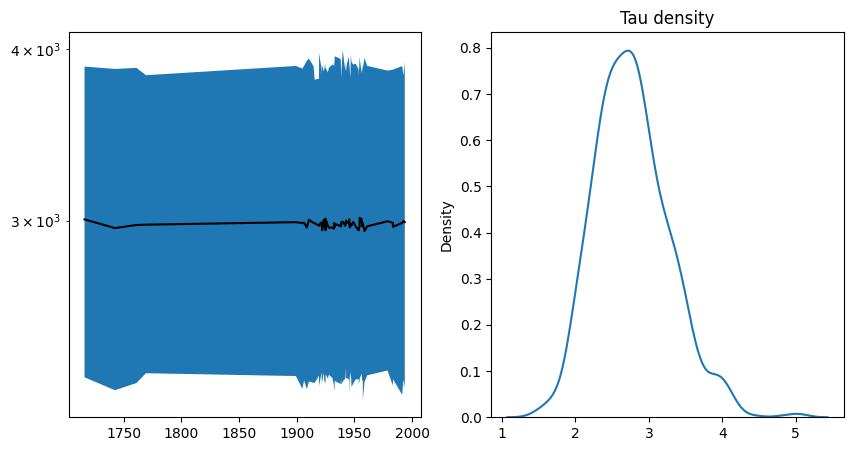

In [41]:
joint, pop_sizes, precision, log_pop_sizes = create_joint_skyride_constrained()

thetas_mu = torch.tensor([8.]*(taxon_count-1), requires_grad=True)
thetas_sigma = torch.tensor([-2.]*(taxon_count-1), requires_grad=True)
tau_mu = torch.tensor([1.], requires_grad=True)
tau_sigma = torch.tensor([-1.7], requires_grad=True)

q_pop_sizes, q_pop_sizes_loc, q_pop_sizes_scale = create_normal(log_pop_sizes, thetas_mu, thetas_sigma)
q_precision, q_precision_loc, q_precision_scale = create_lognormal(precision, tau_mu, tau_sigma)
q_logn_start = JointDistributionModel("var", [q_pop_sizes, q_precision])

samples_start_logn = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_start_logn, 1)
sampler = Sampler(q_logn_start, 1000, [logger])
sampler.run()
samples_start_logn = torch.tensor(samples_start_logn)

f, axes = plt.subplots(1, 2, figsize=(10,5))
thetas = samples_start_logn[:, 1:-1]
mm =torch.mean(thetas, 0)
quants = torch.quantile(thetas, torch.tensor((0.025, 0.5, 0.975)), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

sns.kdeplot(samples_start_logn[:, -1], ax=axes[1])
axes[1].set_title('Tau density')
plt.show()

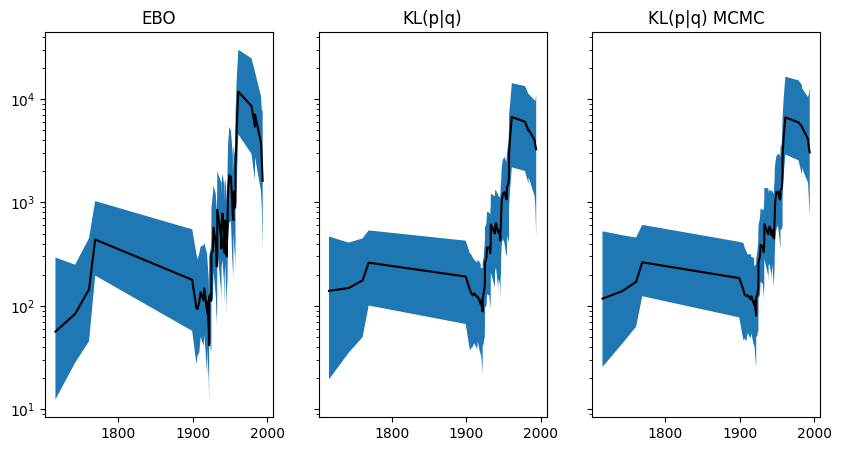

In [42]:
f, axes = plt.subplots(1, 3, figsize=(10,5), sharey=True)

thetas = samples_elbo_logn[:, 1:-1]
mm =torch.mean(thetas, 0)
quants = torch.quantile(thetas, torch.tensor((0.025, 0.5, 0.975)), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')
axes[0].set_title('EBO')

thetas = samples_klpq_bu[:, 1:-1]
mm =torch.mean(thetas, 0)
quants = torch.quantile(thetas, torch.tensor((0.025, 0.5, 0.975)), 0)
axes[1].plot(times, quants[1], 'k-')
axes[1].fill_between(times, quants[0], quants[2])
axes[1].set_yscale('log')
axes[1].set_title('KL(p|q)')

thetas = samples_klpq_bu_logn[:, 1:-1]
mm =torch.mean(thetas, 0)
quants = torch.quantile(thetas, torch.tensor((0.025, 0.5, 0.975)), 0)
axes[2].plot(times, quants[1], 'k-')
axes[2].fill_between(times, quants[0], quants[2])
axes[2].set_yscale('log')
axes[2].set_title('KL(p|q) MCMC')

plt.show()

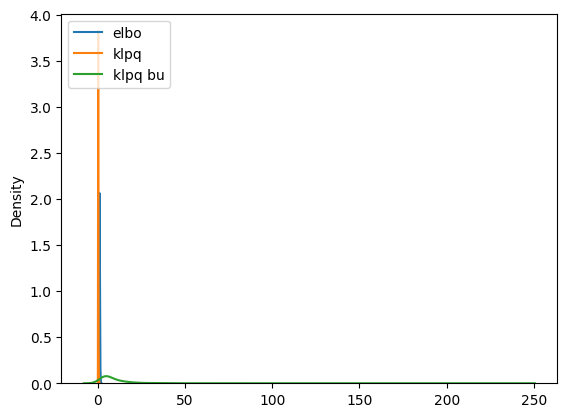

In [43]:
sns.kdeplot(samples_elbo_logn[:, -1], label="elbo")
sns.kdeplot(samples_klpq_logn[:, -1], label="klpq")
sns.kdeplot(samples_klpq_bu_logn[:, -1], label="klpq bu")
plt.legend(loc="upper left")
plt.show()

## Meanfield on $\boldsymbol{\Delta}$, non-centered parameterization, GMRF, and $Gamma(\tau)$

\begin{align}
\begin{aligned}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, 1/\tau)\\
\tau \sim \mathit{Gamma}(0.001,0.001)\\
p_{\tilde\theta}(\tilde\theta_2, \dots, \tilde\theta_N, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{aligned}
\end{align}

\begin{align}
\begin{aligned}
p(\tilde\theta_N, \Delta_2, \dots, \Delta_{N-1}, \tau \mid T) &= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) |det J| \\
&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) \left|\prod_{i=2}^N \frac{d}{d \Delta_i}\tilde\theta_{i-1} + \Delta_i \right|\\
&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T)\\
%&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) \left|\prod_{i=2}^N \frac{d}{d \Delta_i} \tilde\theta_1 + \sum_{j=2}^{i}\Delta_j \right|\\
\end{aligned}
\end{align}

### Variational model: meanfield normal

Meanfield normal distribution on $\boldsymbol{\Delta}$ and $\tilde\theta_1$:
$$ q(\tilde\theta_N, \Delta_2, \dots, \Delta_{N-1}, \tau; \mu, \sigma) = LogNormal(\tau; \mu_\tau, \sigma_\tau) Normal(\tilde\theta_N; \mu_N, \sigma_N) \prod_{i=2}^{N-1} Normal(\Delta_i; \mu_i, \sigma_i)$$

In [44]:
theta_mu = torch.tensor([8.0], requires_grad=True)
theta_sigma = torch.tensor([-2.0], requires_grad=True)
deltas_mu = torch.tensor([-0.05]*(taxon_count-2), requires_grad=True)
deltas_sigma = torch.tensor([-2.2]*(taxon_count-2), requires_grad=True)
tau_mu = torch.tensor([4.2], requires_grad=True)
tau_sigma = torch.tensor([-1.7], requires_grad=True)

optimizer = torch.optim.Adam((theta_mu, theta_sigma, 
                              deltas_mu, deltas_sigma, 
                              tau_mu, tau_sigma),
                              lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# gamma prior on precision parameter tau
prior_tau = torch.distributions.Gamma(0.001, 0.001)
prior_theta = torch.distributions.Normal(mle.log(), 10)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
    q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
    q_tau = torch.distributions.LogNormal(tau_mu, tau_sigma.exp())
    log_theta = q_theta.rsample()
    deltas = q_deltas.rsample()
    tau = q_tau.rsample()
    
    logQ = q_theta.log_prob(log_theta) + q_deltas.log_prob(deltas).sum() + q_tau.log_prob(tau)
    
    thetas = torch.cat((log_theta, deltas)).cumsum(0).exp()
    
    # GMRF prior
    scale = torch.tensor([1.0])/tau.sqrt()
    prior_gmrf = torch.distributions.Normal(0, scale)
    
    log_prior = prior_theta.log_prob(log_theta) + prior_gmrf.log_prob(deltas).sum() + prior_tau.log_prob(
            tau) + prior_theta.log_prob(log_theta[0])
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(heights)

    loss = -(logP + log_prior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

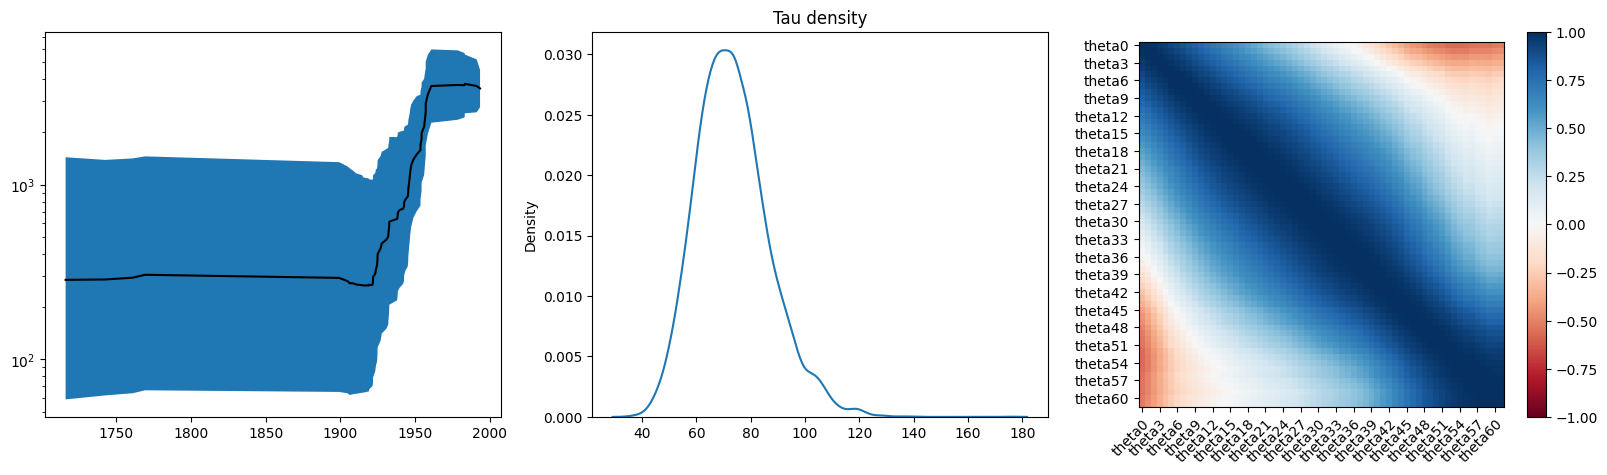

In [45]:
f, axes = plt.subplots(1, 3, figsize=(20,5))

q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
theta = q_theta.sample((10000,))
deltas = q_deltas.sample((10000,))

thetas = torch.cat((theta, deltas), dim=1).cumsum(1).exp()
mm =torch.mean(thetas, 0)
quants = torch.quantile(thetas, torch.tensor((0.025, 0.5, 0.975)), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

taus = torch.distributions.LogNormal(tau_mu, tau_sigma.exp()).sample((10000,))
taus = taus.numpy().flatten()
sns.kdeplot(taus, ax=axes[1])
axes[1].set_title('Tau density')

axes[2].set_xticks(torch.arange(0, thetas.shape[1], 3))
axes[2].set_yticks(torch.arange(0, thetas.shape[1], 3))
im = axes[2].imshow(torch.corrcoef(torch.cov(thetas.t())), vmin=-1, vmax=1, cmap='RdBu')
axes[2].set_xticklabels(['theta{}'.format(i) for i in range(0, thetas.shape[1], 3)])
axes[2].set_yticklabels(['theta{}'.format(i) for i in range(0, thetas.shape[1], 3)])

plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im, ax=axes[2])

plt.show()

# HMC <a name="hcv-hmc"></a>

In [46]:
from torchtree.inference.mcmc.mcmc import MCMC
from torchtree.inference.hmc.operator import HMCOperator
from torchtree.inference.mcmc.operator import SlidingWindowOperator
from torchtree.inference.hmc.integrator import LeapfrogIntegrator
from torchtree.core.logger import ContainerLogger

### Skyride with HMC

In [47]:
joint, pop_sizes, precision, log_pop_sizes = create_joint_skyride_constrained()

klpq_thetas_mu = torch.tensor([8.]*(taxon_count-1), requires_grad=True)
klpq_thetas_sigma = torch.tensor([-2.]*(taxon_count-1), requires_grad=True)
klpq_tau_mu = torch.tensor([4.2], requires_grad=True)
klpq_tau_sigma = torch.tensor([-1.7], requires_grad=True)

q_pop_sizes, q_pop_sizes_loc, q_pop_sizes_scale = create_normal(log_pop_sizes, klpq_thetas_mu, klpq_thetas_sigma)
q_precision, q_precision_loc, q_precision_scale = create_lognormal(precision, klpq_tau_mu, klpq_tau_sigma)
q = JointDistributionModel("var", [q_pop_sizes, q_precision])
klpq = KLpqImportance("klpq", q, joint, torch.Size((10,)))

optimizer = torch.optim.Adam((klpq_thetas_mu, klpq_thetas_sigma, klpq_tau_mu, klpq_tau_sigma), lr=1.0)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
klpq2 = KLpq("klpq", q, joint, torch.Size((10,)))
convergence_check=VariationalConvergence(klpq2, 1000, (100,))
iterations = 100000
advi = Optimizer([q_pop_sizes_loc, q_pop_sizes_scale, 
                  q_precision_loc, q_precision_scale],
                  klpq, optimizer, iterations, scheduler=scheduler, maximize=False, convergence=convergence_check)
advi.run()

0 ELBO -546.0260009765625
1000 ELBO -604.4946899414062
2000 ELBO -557.44482421875
3000 ELBO -541.8975830078125
4000 ELBO -535.8081665039062
5000 ELBO -524.2877197265625
6000 ELBO -505.0601806640625
7000 ELBO -500.7700500488281
8000 ELBO -490.40582275390625
9000 ELBO -485.5083312988281
10000 ELBO -486.2115783691406
11000 ELBO -481.61114501953125
12000 ELBO -481.172119140625
13000 ELBO -479.8127136230469
14000 ELBO -470.25408935546875
15000 ELBO -476.9404602050781
16000 ELBO -470.3531494140625
17000 ELBO -475.43865966796875
18000 ELBO -475.74395751953125
19000 ELBO -472.6735534667969
20000 ELBO -473.88671875
21000 ELBO -473.94793701171875
22000 ELBO -472.68115234375
23000 ELBO -473.530029296875
24000 ELBO -474.02423095703125
25000 ELBO -475.08056640625
26000 ELBO -474.8470153808594
27000 ELBO -474.0932922363281
28000 ELBO -471.8512878417969
29000 ELBO -475.82525634765625
30000 ELBO -470.56280517578125
31000 ELBO -469.0156555175781
32000 ELBO -473.99237060546875
33000 ELBO -474.1423645019

In [48]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skyride()

integrator = LeapfrogIntegrator("leapfrog", 5, 0.1)
mass_matrix = Parameter("mass_matrix", torch.ones(taxon_count))
operator = HMCOperator("operator", joint, [log_pop_sizes, log_precision], integrator, mass_matrix)
samples_hmc = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_hmc, 100)
iterations = 10000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator 0.7868 10000 0.1309380163741582


### Skygrid with HMC

In [49]:
theta_count = 75
cutoff = hcv_heights_list[-1]
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skygrid(theta_count, cutoff)

integrator = LeapfrogIntegrator("leapfrog", 5, 0.1)
mass_matrix = Parameter("mass_matrix", torch.ones(theta_count + 1))
operator = HMCOperator("operator", joint, [log_pop_sizes, log_precision], integrator, mass_matrix)
samples_skygrid_hmc = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skygrid_hmc, 100)
iterations = 10000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator 0.8687 10000 0.1389358501789702


### Skyride with MCMC
Population size and precision parameters are sampled using sliding windows operators.

In [50]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skyride()

samples_skyride_mcmc = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skyride_mcmc, 100)
operator_pop = SlidingWindowOperator("operator1", [log_pop_sizes], 1, 0.24, 0.9)
operator_precision = SlidingWindowOperator("operator2", [log_precision], 1, 0.24, 0.9)
iterations = 100000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator_pop, operator_precision], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator1 0.6738852485216558 50056 1.2242318512027188
operator2 0.23372176838058625 49944 2.5025827317514686


### Skygrid with MCMC
Population size and precision parameters are sampled using sliding windows operators.

In [51]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skygrid(theta_count, cutoff)

samples_skygrid_mcmc = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skygrid_mcmc, 100)
operator_pop = SlidingWindowOperator("operator1", [log_pop_sizes], 1, 0.24, 0.9)
operator_precision = SlidingWindowOperator("operator2", [log_precision], 1, 0.24, 0.9)
iterations = 100000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator_pop, operator_precision], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator1 0.40955904409559046 50005 4.314589376650743
operator2 0.23616361636163616 49995 2.207607866298773


### Skyride with MCMC and block updating
Population size and precision parameters are sampled using a block updating operator.

In [52]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skyride()
skyride = joint._distributions.skyride
gmrf = joint._distributions.gmrf

samples_skyride_mcmc_bu = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skyride_mcmc_bu, 100)
operator = GMRFPiecewiseCoalescentBlockUpdatingOperator("operator2", [log_precision, log_pop_sizes], skyride, gmrf, 1, 0.24, 2.0)
iterations = 10000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator2 0.2942 10000 tensor(6.0428)


### Skygrid with MCMC and block updating
Population size and precision parameters are sampled using a block updating operator.

In [53]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skygrid(theta_count, cutoff)
skygrid = joint._distributions.skygrid
gmrf = joint._distributions.gmrf

samples_skygrid_mcmc_bu = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skygrid_mcmc_bu, 100)
operator = GMRFPiecewiseCoalescentBlockUpdatingOperator("operator2", [log_precision, log_pop_sizes], skygrid, gmrf, 1, 0.24, 2.0)
iterations = 10000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator2 0.2648 10000 tensor(3.3358)


In [54]:
samples_skygrid_hmc = torch.tensor(samples_skygrid_hmc)
samples_skygrid_mcmc = torch.tensor(samples_skygrid_mcmc)
samples_skygrid_mcmc_bu = torch.tensor(samples_skygrid_mcmc_bu)

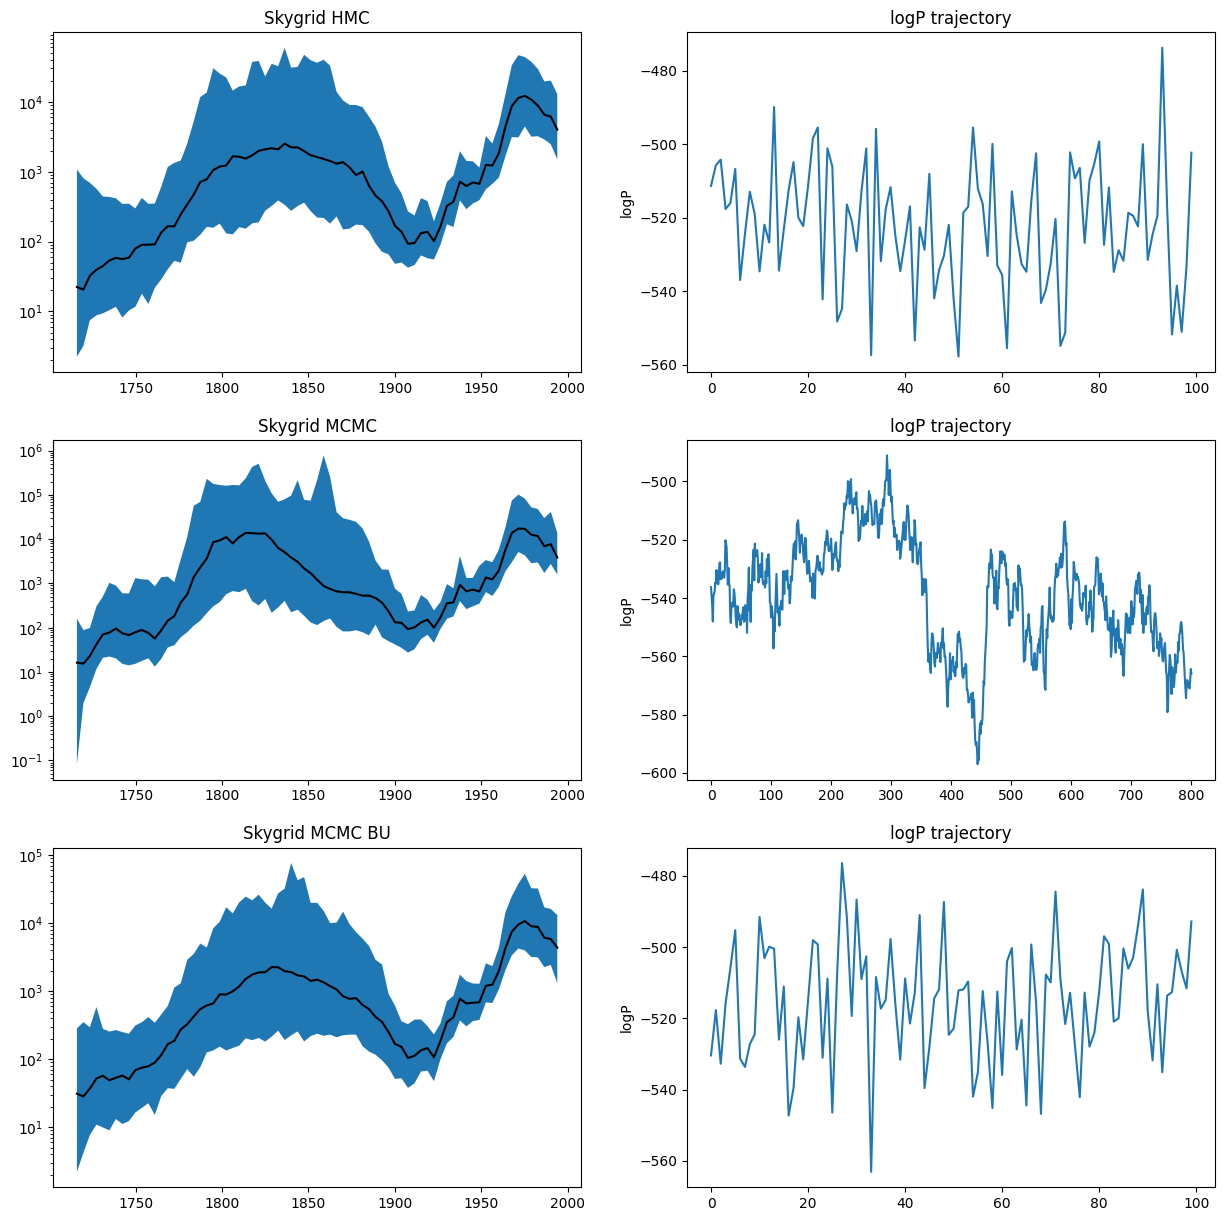

In [55]:
f, axes = plt.subplots(3, 2, figsize=(15,15))
q = torch.tensor((0.025, 0.5, 0.975))
grid = 1994 - torch.linspace(0, cutoff, theta_count)

thetas_skygrid_hmc=samples_skygrid_hmc[1:,1:-1]
quants = torch.quantile(thetas_skygrid_hmc, q, 0)
axes[0,0].plot(grid, quants[1], 'k-')
axes[0,0].fill_between(grid, quants[0], quants[2])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Skygrid HMC')

thetas_skygrid_mcmc=samples_skygrid_mcmc[200:,1:-1]
quants = torch.quantile(thetas_skygrid_mcmc, q, 0)
axes[1,0].plot(grid, quants[1], 'k-')
axes[1,0].fill_between(grid, quants[0], quants[2])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Skygrid MCMC')

thetas_skygrid_mcmc_bu=samples_skygrid_mcmc_bu[1:,1:-1]
quants = torch.quantile(thetas_skygrid_mcmc_bu, q, 0)
axes[2,0].plot(grid, quants[1], 'k-')
axes[2,0].fill_between(grid, quants[0], quants[2])
axes[2,0].set_yscale('log')
axes[2,0].set_title('Skygrid MCMC BU')

axes[0,1].plot(samples_skygrid_hmc[1:,:1])
axes[0,1].set_title('logP trajectory')
axes[0,1].set_ylabel('logP')

axes[1,1].plot(samples_skygrid_mcmc[200:,:1])
axes[1,1].set_title('logP trajectory')
axes[1,1].set_ylabel('logP')

axes[2,1].plot(samples_skygrid_mcmc_bu[1:,:1])
axes[2,1].set_title('logP trajectory')
axes[2,1].set_ylabel('logP')

plt.show()

In [56]:
samples_hmc = torch.tensor(samples_hmc)
samples_skyride_mcmc = torch.tensor(samples_skyride_mcmc)
samples_skyride_mcmc_bu = torch.tensor(samples_skyride_mcmc_bu)

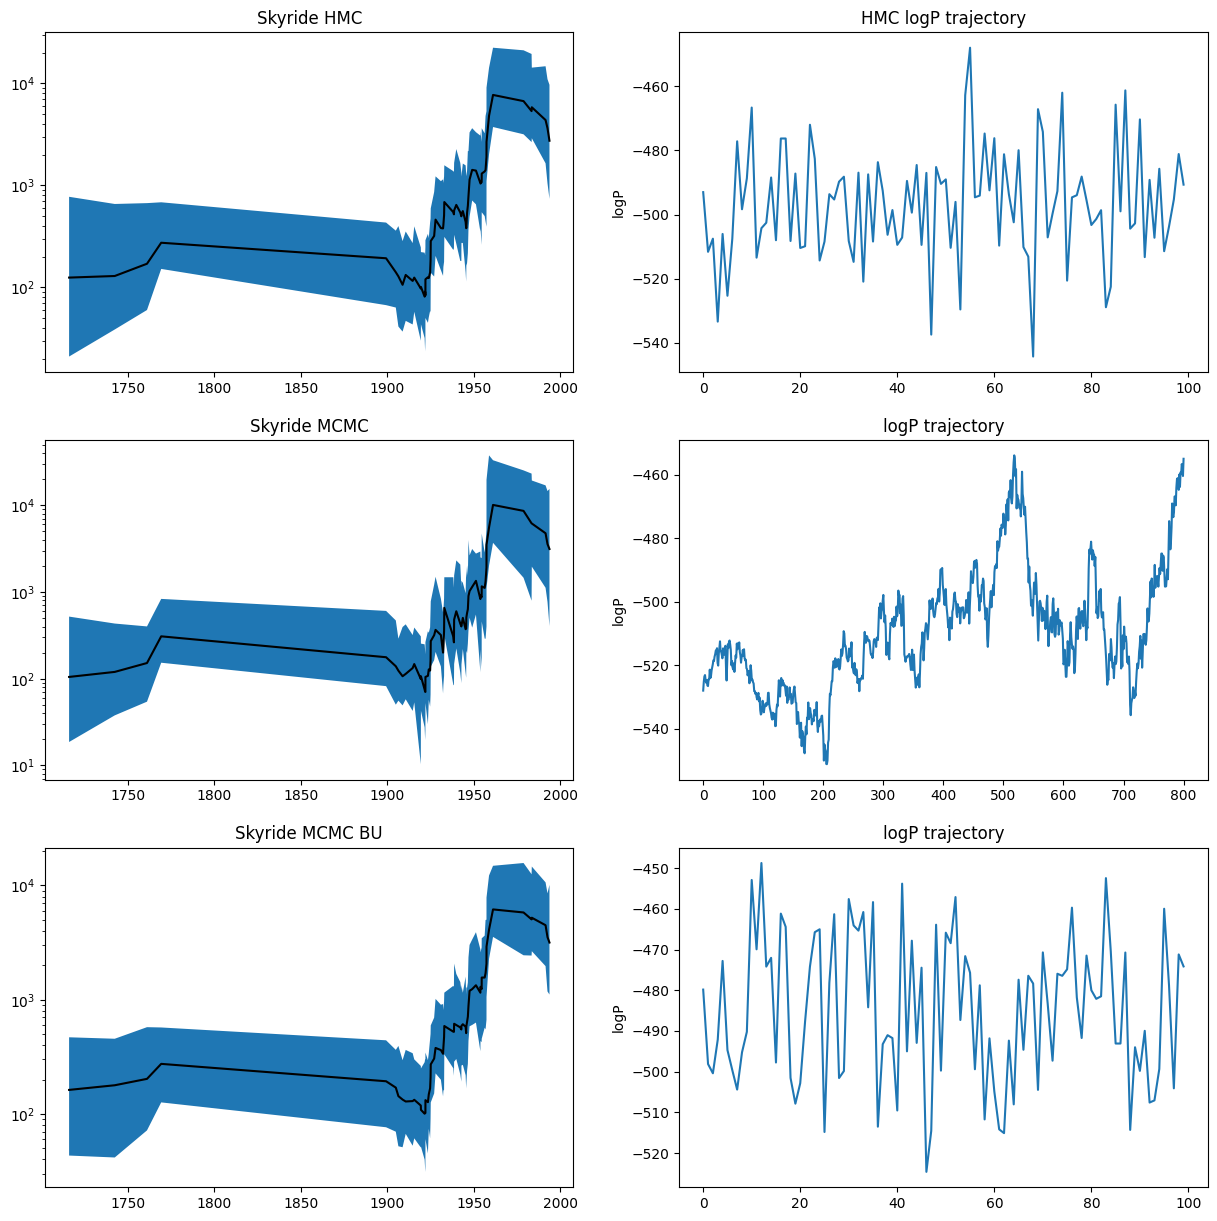

In [57]:
f, axes = plt.subplots(3, 2, figsize=(15,15))

thetas_hmc=samples_hmc[1:,1:-1]
quants = torch.quantile(thetas_hmc, q, 0)
axes[0,0].plot(times, quants[1], 'k-')
axes[0,0].fill_between(times, quants[0], quants[2])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Skyride HMC')

thetas_skyride_mcmc=samples_skyride_mcmc[200:,1:-1]
quants = torch.quantile(thetas_skyride_mcmc, q, 0)
axes[1,0].plot(times, quants[1], 'k-')
axes[1,0].fill_between(times, quants[0], quants[2])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Skyride MCMC')

thetas_skyride_mcmc_bu=samples_skyride_mcmc_bu[1:,1:-1]
quants = torch.quantile(thetas_skyride_mcmc_bu, q, 0)
axes[2,0].plot(times, quants[1], 'k-')
axes[2,0].fill_between(times, quants[0], quants[2])
axes[2,0].set_yscale('log')
axes[2,0].set_title('Skyride MCMC BU')

axes[0,1].plot(samples_hmc[1:,:1])
axes[0,1].set_title('HMC logP trajectory')
axes[0,1].set_ylabel('logP')

axes[1,1].plot(samples_skyride_mcmc[200:,:1])
axes[1,1].set_title('logP trajectory')
axes[1,1].set_ylabel('logP')

axes[2,1].plot(samples_skyride_mcmc_bu[1:,:1])
axes[2,1].set_title('logP trajectory')
axes[2,1].set_ylabel('logP')

plt.show()

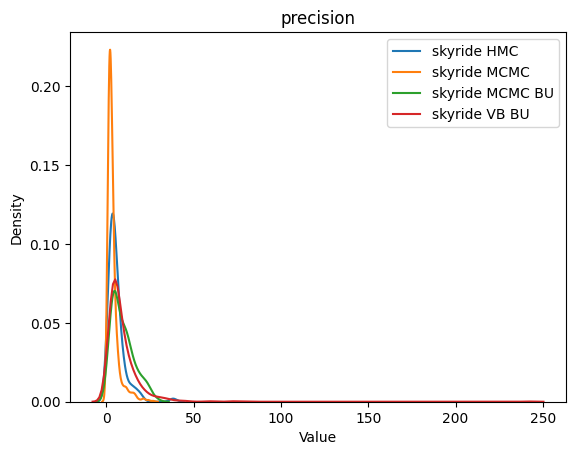

In [58]:
sns.kdeplot(samples_hmc[1:,-1], label='skyride HMC')
sns.kdeplot(samples_skyride_mcmc[200:,-1], label='skyride MCMC')
sns.kdeplot(samples_skyride_mcmc_bu[1:,-1], label='skyride MCMC BU')
sns.kdeplot(samples_klpq_bu_logn[1:,-1], label='skyride VB BU')

plt.xlabel('Value')
plt.title('precision')
plt.legend(loc="upper right")
plt.show()

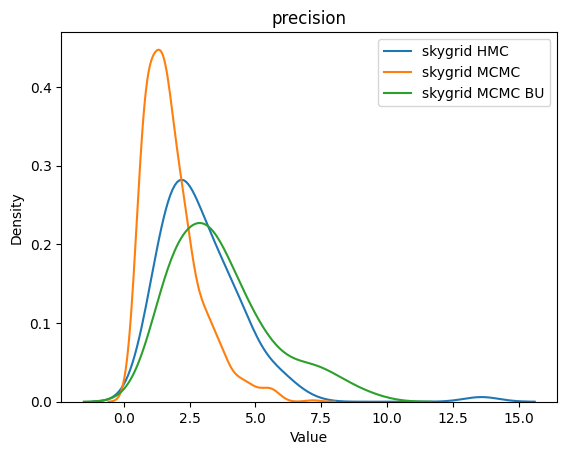

In [59]:
sns.kdeplot(samples_skygrid_hmc[1:,-1], label='skygrid HMC')
sns.kdeplot(samples_skygrid_mcmc[200:,-1], label='skygrid MCMC')
sns.kdeplot(samples_skygrid_mcmc_bu[1:,-1], label='skygrid MCMC BU')

plt.xlabel('Value')
plt.title('precision')
plt.legend(loc="upper right")
plt.show()